# Telco-churn-classification-project

## Project Goals

* The goal of this project is to identify the attributes of customers churn rate in Telco company in order to make recommendations of how to reduce churan rate for Telco company.


## Initial Questions

1. Is the churn rate effected by monthly charges?

2. Is the churn rate effected by providers?

3. Does churn rate related to tenure?

4. Does the churn rate related to the additional services?

5. Does the churn rate effeted by partner and dependent?

6. Does the churn rate effeted by contract type?

## Data Dictionary

Variables are used in this analyst: 

* churn
* monthly charges
* tenure
* contract types: month-to-month, one-year, two-year
* additional services: online security, online backup, tech support, streaming tv, streaming movies
* contract type: month-to-month, one-year, two-year
* partners and dependents number

## Wrangle Telco Data
#### To acquire the telco churn data, I used the telco_churn in our mySQL server Then selected all columns from the customers table and left join internet_service_types, payment_types and contract_types tables.

* select * from customers left join internet_service_types using(internet_service_type_id) left join payment_types using (payment_type_id) left join contract_types using (contract_type_id)

In [56]:
# Acquire telco_churn data from MySql database 
import acquire_telco

# Make the commection to the database and run the query. Then we will get the data we need.
df = acquire_telco.new_telco_data()

In [43]:
import pandas as pd
import env
import os
import acquire_telco
import prepare_telco
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [57]:
df = acquire_telco.new_telco_data()
df.shape

(7043, 24)

#### To clean the data, I did the following:
    
1. Convert data type: convert total_charges from object to float.
2. Drop rows: There are 11 missing data for total_charges, since it's a very small portion, so I just dropped those 11 rows.
3. Drop coolumns: Since I already added internet_service_types, payment_types and contract_types into my data, so I dropped payment_type_id, internet_service_type_id znd contract_type_id columns.
4. Encode binary categorical variables into numeric values: gender, partner, dependents, phone_service, paperless_billing, churn, online_security, online_backup.
5. Get dummies for non-binary categorical variables: multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, contract_type, internet_service_type, payment_type.

In [4]:
import prepare_telco

train, validate, test = prepare_telco.prep_telco_data(df)

print(train.shape)
print(validate.shape)
print(test.shape)

(4500, 55)
(1125, 55)
(1407, 55)


* Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.
* The validate is used to verify that our models built are not overfit to the train dataset.
* The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

# Exploration on train set

<AxesSubplot:xlabel='churn', ylabel='Count'>

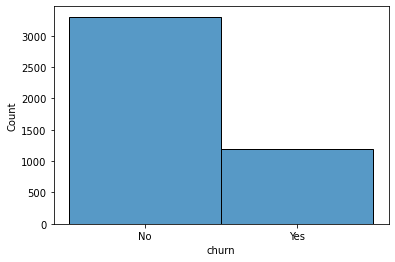

In [5]:
# Overall churn rate on train set
sns.histplot(train.churn)

In [4]:
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [7]:
churn_rate = 1196/(3304+1196)
churn_rate

0.2657777777777778

## 1. Is the churn rate effected by monthly charges?

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# mean of monthly charges for customers who churn vs who don't churn?

train.groupby('churn').monthly_charges.mean()

churn
No     61.131613
Yes    74.652048
Name: monthly_charges, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

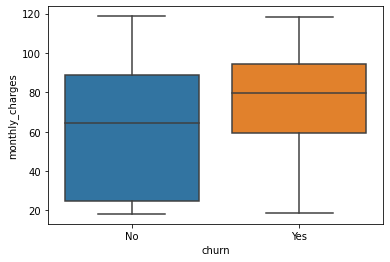

In [15]:
sns.boxplot(data = train, y = 'monthly_charges', x = 'churn')

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

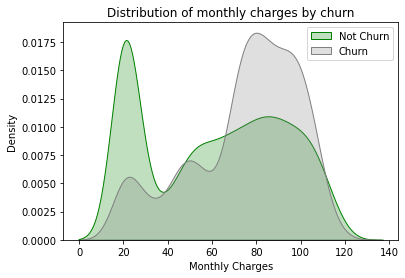

In [115]:
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'No') ],
                color="green", shade = True)
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'Yes') ],
                ax =ax, color="grey", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

* correlation: 2 continuous variables, normally distributed, testing for LINEAR correlation only (H_0: Not linearly dependent)

* independent t-test: 1 continuous, somewhat normally distributed variable, one boolean variable, equal variance, independent (H_0: population mean of each group is equal)

* chi-square test: 2 discrete variables. (H_0: the 2 variables are independent of each other).

### statistical test ---- t-test (2 sample 1-tailed test)

I believe customers who churn are charged more (monthly average) than customers who don't churn.

Is the mean of monthly charges of customers who churn significantly higher than the mean of those who don't churn?

<AxesSubplot:>

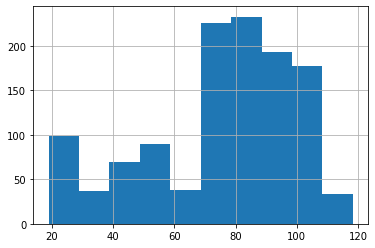

In [66]:
# histogram of churned customers
churn_sample = train[train.churn == 'Yes'].monthly_charges

churn_sample.hist()

<AxesSubplot:>

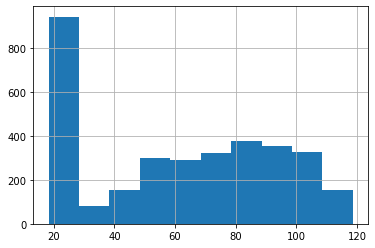

In [67]:
no_churn_sample = train[train.churn == 'No'].monthly_charges

no_churn_sample.hist()

* Set Hypothesis

H0: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who haven't churned.

Ha: Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned.

* set alpha

In [68]:
alpha = 0.05

* Verify Assumptions

1. Independent Samples. YES! no observations in the churn sample exist in the no-churn sample.

2. Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT). YES! Plenty of observations

3. Equal Variances (the scipy methods we will use has an argument to handle when variances aren't equal).

In [28]:
churn_sample.var(), no_churn_sample.var()

(610.5202363859298, 973.6230640332021)

In [69]:
import scipy.stats as stats

t, p = stats.ttest_ind(churn_sample,no_churn_sample, equal_var=False)

t, p

(15.067898021010361, 2.7212506175344626e-49)

In [70]:
t, p/2, alpha

(15.067898021010361, 1.3606253087672313e-49, 0.05)

In [71]:
if (p/2 < alpha) & (t > 0):
    print("Reject null. The monthly charges for churn customers is higher than non-churn customers.")
else:
    print("Fail to reject null. The monthly charges for churn customers is equal or lower than non-churn customers.")

Reject null. The monthly charges for churn customers is higher than non-churn customers.


### ---- Customers who have high monthly charges are more like to churn

## 2. Is the churn rate effected by different providers?

<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

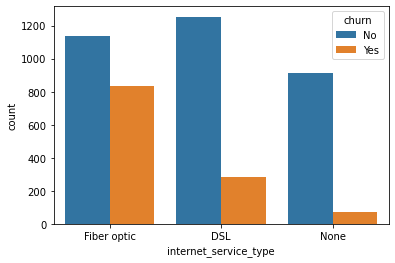

In [96]:
sns.countplot(x = 'internet_service_type', hue = 'churn', data = train)

In [41]:
pd.crosstab(train.internet_service_type, train.churn, margins=True)

churn,No,Yes,All
internet_service_type,,,
DSL,1254,286,1540
Fiber optic,1135,837,1972
None,915,73,988
All,3304,1196,4500


In [39]:
ctab_service_type = pd.crosstab(train.internet_service_type, train.churn, normalize = 'index')
ctab_service_type

churn,No,Yes
internet_service_type,,
DSL,0.814286,0.185714
Fiber optic,0.575558,0.424442
None,0.926113,0.073887


### Chi2 test -----  service type and churn

* H0: There is no association between the providers and churn (independence).
* Ha: There is a association between the providers and churn (dependent).


In [44]:
# pandas crosstab to make a 'contingency' table
observed = pd.crosstab(train.churn, train.internet_service_type)
observed

internet_service_type,DSL,Fiber optic,None
churn,,,
No,1254,1135,915
Yes,286,837,73


In [45]:
# Set our alpha

alpha = 0.05

In [46]:
# chi2_contingency returns 4 different values

chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(491.4211645300569,
 1.946480140479697e-107,
 2,
 array([[1130.70222222, 1447.88622222,  725.41155556],
        [ 409.29777778,  524.11377778,  262.58844444]]))

In [47]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1254 1135  915]
 [ 286  837   73]]
---
Expected

[[1130 1447  725]
 [ 409  524  262]]
---

chi^2 = 491.4212
p     = 0.0000


In [49]:
if p < alpha:
    print('We reject the null. There is a association between churn rate and providers.')
else:
    print("we fail to reject the null")

We reject the null. There is a association between churn rate and providers.


### --- Customers with Fiber are more like to churn.

## 3. Does churn rate related to tenure?

<AxesSubplot:xlabel='churn', ylabel='tenure'>

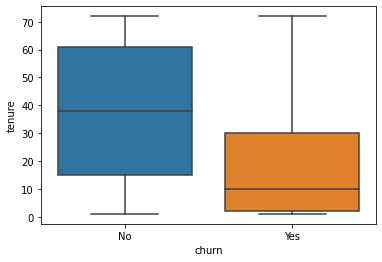

In [55]:
sns.boxplot(x = 'churn', y = 'tenure', data = train)

In [56]:
train.groupby('churn').tenure.mean()

churn
No     37.689770
Yes    18.061037
Name: tenure, dtype: float64

### T-test : 2 sample 1-teailed

I believe that the mean of tenure for churn customers is lower than non-churn customers.

* H0: Mean of tenure for churn customers >= non-churn customers.

* H1: Mean of tenure for churn customers < non-churn customers.

<AxesSubplot:>

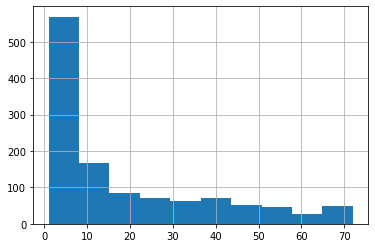

In [83]:
# histogram of churned customers
churn_sample_tenure = train[train.churn == 'Yes'].tenure

churn_sample_tenure.hist()

<AxesSubplot:>

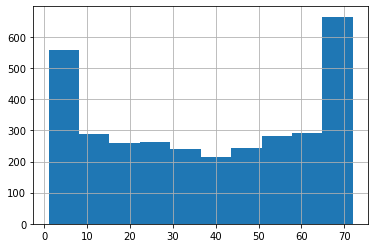

In [84]:
no_churn_sample_tenure = train[train.churn == 'No'].tenure

no_churn_sample_tenure.hist()

In [85]:
alpha = 0.05

In [86]:
churn_sample_tenure.var(), no_churn_sample_tenure.var()

(391.3711667902756, 583.9458111490103)

In [87]:
t1, p1 = stats.ttest_ind(churn_sample_tenure,no_churn_sample_tenure, equal_var=False)

t1, p1

(-27.649600939497784, 1.6885266797494086e-147)

In [88]:
t1, p1/2, alpha

(-27.649600939497784, 8.442633398747043e-148, 0.05)

In [91]:
if (p1/2 < alpha) & (t1 < 0):
    print("Reject null. Mean of tenure for churn customers is less then non-churn customers.")
else:
    print("Fail to reject null. ")

Reject null. Mean of tenure for churn customers is less then non-churn customers.


### --- The churn customers have less tenure.

## 4. Does the churn rate related to the additional services?

<AxesSubplot:xlabel='additional_services', ylabel='count'>

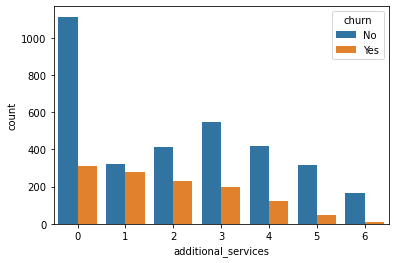

In [6]:
sns.countplot(x = 'additional_services', hue = 'churn', data = train)

### --- The more additional services use, the churn rate is lower.

# 5. Does the churn rate effeted by partner and dependent?

In [111]:
pd.crosstab(train.number_relationships, train.churn, normalize = 'index')

churn,No,Yes
number_relationships,,
0,0.654085,0.345915
1,0.754454,0.245546
2,0.861111,0.138889


<AxesSubplot:xlabel='number_relationships', ylabel='count'>

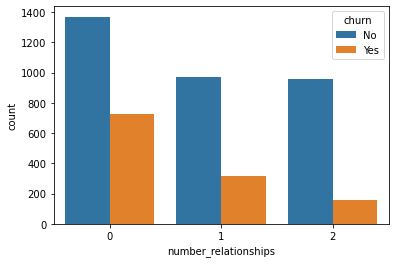

In [112]:
sns.countplot(x = 'number_relationships', hue = 'churn', data = train)

### --- Customers who have partners or dependents are less likely to churn. 

# 6. Does the churn rate effeted by contract type?

<AxesSubplot:xlabel='contract_type', ylabel='count'>

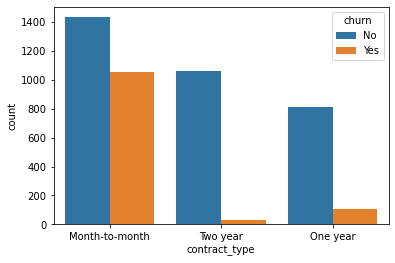

In [105]:
sns.countplot(x = 'contract_type', hue = 'churn', data = train)

### --- Month-to-month contract type has higher churn rate.

## Summary: 

1. Customers who have high monthly charges are more like to churn.
2. Customers with Fiber are more like to churn.
3. The churn customers have less tenure.
4. The more additional services use, the churn rate is lower.
5. Customers who have partners or dependents are less likely to churn.
6. Month-to-month contract type has higher churn rate.

#### Therefore, features I will use are: 
#### monthly charges, providers, tenure, addtional services, partners and dependents' number, contracts type.

# Modeling

In [21]:
# create a baseline on train set
train.churn_encoded.value_counts()

0    3304
1    1196
Name: churn_encoded, dtype: int64

In [7]:
train['baseline_churn'] = 0

In [8]:
baseline_churn_accuracy = (train.churn_encoded == train.baseline_churn).mean()

print(f'baseline accuracy on train set: {baseline_churn_accuracy:.2%}')

baseline accuracy: 73.42%


In [11]:
from sklearn.metrics import classification_report

print(classification_report(train.churn_encoded, train.baseline_churn))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      3304
           1       0.00      0.00      0.00      1196

    accuracy                           0.73      4500
   macro avg       0.37      0.50      0.42      4500
weighted avg       0.54      0.73      0.62      4500



## Model 1 : Random forest

In [269]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [373]:
x_train = train[['monthly_charges', 'internet_service_type_Fiber optic','internet_service_type_None', 
                 'contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services',
                 'number_relationships']]
y_train = train.churn_encoded

x_validate = validate[['monthly_charges', 'internet_service_type_Fiber optic','internet_service_type_None', 
                       'contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services', 
                       'number_relationships']]
y_validate = validate.churn_encoded

x_test = test[['monthly_charges', 'internet_service_type_Fiber optic','internet_service_type_None', 
               'contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services', 
               'number_relationships']]
y_test = test.churn_encoded

In [341]:
x_train.head()

,monthly_charges,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,tenure,additional_services,number_relationships
4216,84.30,1,0,0,0,18,1,0
1477,58.55,0,0,0,0,29,2,0
5752,24.75,0,1,0,1,72,0,0
1377,84.20,0,0,0,1,65,5,2
3965,99.25,1,0,1,0,58,4,2


In [24]:
y_train[:5]

4216    0
1477    0
5752    0
1377    0
3965    0
Name: churn_encoded, dtype: int64

In [374]:
# Create the object -------- Create the Random Forest object with desired hyper-parameters

rf = RandomForestClassifier(max_depth=3,
                            random_state=123)
rf

RandomForestClassifier(max_depth=3, random_state=123)

In [36]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 4216 to 3374
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   monthly_charges                    4500 non-null   float64
 1   internet_service_type_Fiber optic  4500 non-null   uint8  
 2   internet_service_type_None         4500 non-null   uint8  
 3   contract_type_One year             4500 non-null   uint8  
 4   contract_type_Two year             4500 non-null   uint8  
 5   tenure                             4500 non-null   int64  
 6   additional_services                4500 non-null   int64  
 7   number_relationships               4500 non-null   int64  
dtypes: float64(1), int64(3), uint8(4)
memory usage: 193.4 KB


In [375]:
# Fit the model ------- Fit the random forest algorithm to the training data.

rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, random_state=123)

In [376]:
# Make Predictions --------  Classify each flower by its estimated species.

y_pred1 = rf.predict(x_train)
y_pred1

array([0, 0, 0, ..., 0, 0, 1])

In [377]:
# Estimate Probability ------- Estimate the probability of each species, using the training data.

y_pred_proba1 = rf.predict_proba(x_train)
y_pred_proba1

array([[0.56598533, 0.43401467],
       [0.78268865, 0.21731135],
       [0.9636286 , 0.0363714 ],
       ...,
       [0.97180725, 0.02819275],
       [0.61254699, 0.38745301],
       [0.42779762, 0.57220238]])

In [378]:
print(classification_report(y_train, y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3304
           1       0.71      0.39      0.50      1196

    accuracy                           0.79      4500
   macro avg       0.76      0.66      0.68      4500
weighted avg       0.78      0.79      0.77      4500



In [379]:
print('Accuracy of random forest classifier on train set: {:.2f}'
     .format(rf.score(x_train, y_train)))

Accuracy of random forest classifier on train set: 0.79


In [380]:
# validate model

print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(x_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.78


In [291]:
TN, FP, FN, TP = confusion_matrix(y_train, y_pred1).ravel()
TN, FP, FN, TP

(3112, 192, 734, 462)

In [292]:
negative_cases = TN + FP
positive_cases = FN + TP
print(f"Negative Cases: {negative_cases}")
print(f"Positive Cases: {positive_cases}")
print(y_train.value_counts())

Negative Cases: 3304
Positive Cases: 1196
0    3304
1    1196
Name: churn_encoded, dtype: int64


In [293]:
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
true_positive_rate = sensitivity = recall = power = TP/(TP+FN)
false_positive_rate = false_alarm_ratio = fallout = FP/(FP+TN)
true_negative_rate = specificity = selectivity = TN/(TN+FP)
false_negative_rate = miss_rate = FN/(FN+TP)
precision = PPV = TP/(TP+FP)
f1_score = 2*(precision*recall)/(precision+recall)
support_pos = TP + FN
support_neg = FP + TN

print(f"Accuracy: {accuracy}", '\n')
print(f"True Positive Rate/Sensitivity/Recall/Power: {true_positive_rate}", '\n')
print(f"False Positive Rate/False Alarm Ratio/Fall-out: {false_positive_rate}", '\n')
print(f"True Negative Rate/Specificity/Selectivity: {true_negative_rate}", '\n')
print(f"False Negative Rate/Miss Rate: {false_negative_rate}", '\n')
print(f"Precision/PPV: {precision}", '\n')
print(f"F1 Score: {f1_score}", '\n')
print(f"Support (0): {support_neg}", '\n')
print(f"Support (1): {support_pos}")

Accuracy: 0.7942222222222223 

True Positive Rate/Sensitivity/Recall/Power: 0.3862876254180602 

False Positive Rate/False Alarm Ratio/Fall-out: 0.05811138014527845 

True Negative Rate/Specificity/Selectivity: 0.9418886198547215 

False Negative Rate/Miss Rate: 0.6137123745819398 

Precision/PPV: 0.7064220183486238 

F1 Score: 0.49945945945945946 

Support (0): 3304 

Support (1): 1196


In [348]:
for i in range(2,20):
    # make the model
    rf = RandomForestClassifier(max_depth=i, 
                            random_state=123)
    
    # fit the model (ont the train and only train)
    rf = rf.fit(x_train, y_train)
    
    # use the model
    # We'll evaluate the model's performance on train, first
    y_pred = rf.predict(x_train)
    
    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    
    print(f'Tree with max depth with {i}')
    print(pd.DataFrame(report))
    print()

Tree with max depth with 2
                     0       1  accuracy    macro avg  weighted avg
precision     0.734222     0.0  0.734222     0.367111      0.539082
recall        1.000000     0.0  0.734222     0.500000      0.734222
f1-score      0.846745     0.0  0.734222     0.423373      0.621699
support    3304.000000  1196.0  0.734222  4500.000000   4500.000000

Tree with max depth with 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.809152     0.706422  0.794222     0.757787      0.781849
recall        0.941889     0.386288  0.794222     0.664088      0.794222
f1-score      0.870490     0.499459  0.794222     0.684974      0.771878
support    3304.000000  1196.000000  0.794222  4500.000000   4500.000000

Tree with max depth with 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.811568     0.701031  0.794889     0.756299      0.782189
recall        0.938559     0.397993  0.794889     0.668276      0.

In [349]:
# ompare in-sample to out-of-sample

metrics = []

for i in range(2,20):
    rf = RandomForestClassifier(max_depth=i,
                            random_state=123)
    
    rf = rf.fit(x_train, y_train)
    
    in_sample_accuracy = rf.score(x_train, y_train)
    
    out_of_sample_accuracy = rf.score(x_validate, y_validate)
    
    output = {"max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
        
    metrics.append(output)
    
df1 = pd.DataFrame(metrics)
df1["difference"] = df1.train_accuracy - df1.validate_accuracy
df1

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.734222,0.734222,0.000000
1,3,0.794222,0.776000,0.018222
2,4,0.794889,0.770667,0.024222
3,5,0.797333,0.771556,0.025778
4,6,0.801778,0.772444,0.029333
5,7,0.806444,0.776889,0.029556
6,8,0.820222,0.776000,0.044222
7,9,0.839333,0.768889,0.070444
8,10,0.856444,0.773333,0.083111
9,11,0.887111,0.777778,0.109333


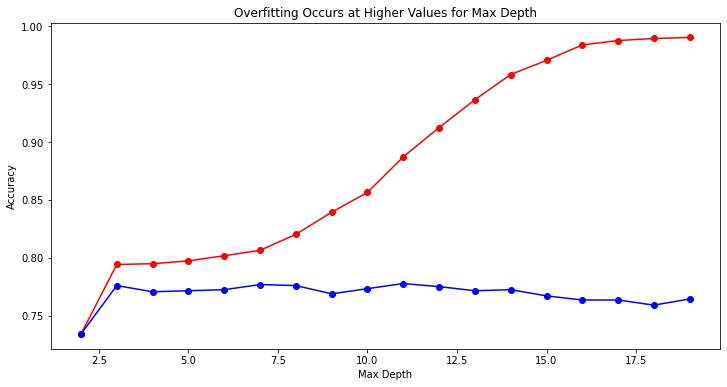

In [350]:
plt.figure(figsize=(12, 6))
plt.plot(df1.max_depth, df1.train_accuracy, color = 'r', marker = 'o')
plt.plot(df1.max_depth, df1.validate_accuracy, color = 'b', marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [351]:
df1[df1.difference <= 0.03].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,train_accuracy,validate_accuracy,difference
5,7,0.806444,0.776889,0.029556
1,3,0.794222,0.776000,0.018222
4,6,0.801778,0.772444,0.029333
3,5,0.797333,0.771556,0.025778
2,4,0.794889,0.770667,0.024222
0,2,0.734222,0.734222,0.000000


### max_depth = 3 is the best choice

In [352]:
print(f'baseline accuracy on train set: {baseline_churn_accuracy:.2%}')
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf.score(x_train, y_train)))

baseline accuracy on train set: 73.42%
Accuracy of random forest classifier on train set: 99.02%


# Model 2 : KNN

In [353]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Object
knn = KNeighborsClassifier(n_neighbors=10)
# n_neighbors=1, weights='uniform'

In [354]:
# Fit the Model to the Training Data
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [355]:
# Make Predictions
y_pred2 = knn.predict(x_train)
y_pred2[:5]

array([0, 0, 0, 0, 0])

In [144]:
y_train[:5]

4216    0
1477    0
5752    0
1377    0
3965    0
Name: churn_encoded, dtype: int64

In [356]:
# Estimate Probability
y_pred_proba2 = knn.predict_proba(x_train)
y_pred_proba2[:5]

array([[0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2]])

In [357]:
print('Accuracy of KNN(k=10) classifier on training set: {:.2%}'
     .format(knn.score(x_train, y_train)))

Accuracy of KNN(k=10) classifier on training set: 81.84%


In [147]:
print(confusion_matrix(y_train, y_pred2))

[[3102  202]
 [ 615  581]]


In [358]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3304
           1       0.74      0.49      0.59      1196

    accuracy                           0.82      4500
   macro avg       0.79      0.71      0.74      4500
weighted avg       0.81      0.82      0.80      4500



In [359]:
TN1, FP1, FN1, TP1 = confusion_matrix(y_train, y_pred2).ravel()
TN1, FP1, FN1, TP1

(3102, 202, 615, 581)

In [360]:
ALL1 = TP1 + FP1 + FN1 + TN1

accuracy = (TP1 + TN1)/ALL1
true_positive_rate = sensitivity = recall = power = TP1/(TP1+FN1)
false_positive_rate = false_alarm_ratio = fallout = FP1/(FP1+TN1)
true_negative_rate = specificity = selectivity = TN1/(TN1+FP1)
false_negative_rate = miss_rate = FN1/(FN1+TP1)
precision = PPV = TP1/(TP1+FP1)
f1_score = 2*(precision*recall)/(precision+recall)
support_pos = TP1 + FN1
support_neg = FP1 + TN1

print(f"Accuracy: {accuracy}", '\n')
print(f"True Positive Rate/Sensitivity/Recall/Power: {true_positive_rate}", '\n')
print(f"False Positive Rate/False Alarm Ratio/Fall-out: {false_positive_rate}", '\n')
print(f"True Negative Rate/Specificity/Selectivity: {true_negative_rate}", '\n')
print(f"False Negative Rate/Miss Rate: {false_negative_rate}", '\n')
print(f"Precision/PPV: {precision}", '\n')
print(f"F1 Score: {f1_score}", '\n')
print(f"Support (0): {support_neg}", '\n')
print(f"Support (1): {support_pos}")

Accuracy: 0.8184444444444444 

True Positive Rate/Sensitivity/Recall/Power: 0.48578595317725753 

False Positive Rate/False Alarm Ratio/Fall-out: 0.061138014527845036 

True Negative Rate/Specificity/Selectivity: 0.9388619854721549 

False Negative Rate/Miss Rate: 0.5142140468227425 

Precision/PPV: 0.7420178799489144 

F1 Score: 0.5871652349671551 

Support (0): 3304 

Support (1): 1196


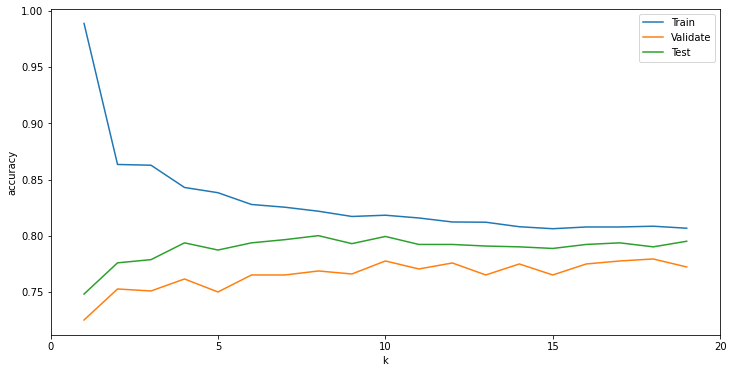

In [361]:
k_range = range(1, 20)
train_scores = []
validate_scores = []
test_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    train_scores.append(knn.score(x_train, y_train))
    validate_scores.append(knn.score(x_validate, y_validate))
    test_scores.append(knn.score(x_test, y_test))
plt.figure(figsize=(12, 6))
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_range, train_scores, label='Train')
plt.plot(k_range, validate_scores, label='Validate')
plt.plot(k_range, test_scores, label='Test')
plt.legend()
plt.xticks([0,5,10,15,20])
plt.show()

### --- K=10 will be the best choice

In [362]:
print(f'Baseline accuracy on train set: {baseline_churn_accuracy:.2%}')
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf.score(x_train, y_train)))
print('Accuracy of KNN(k=10) classifier on training set: {:.2%}'
     .format(knn.score(x_train, y_train)))

Baseline accuracy on train set: 73.42%
Accuracy of random forest classifier on train set: 99.02%
Accuracy of KNN(k=10) classifier on training set: 80.69%


## Model 3: Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression

In [160]:
x_train.head()

,monthly_charges,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,tenure,additional_services,number_relationships
4216,84.30,1,0,0,0,18,1,0
1477,58.55,0,0,0,0,29,2,0
5752,24.75,0,1,0,1,72,0,0
1377,84.20,0,0,0,1,65,5,2
3965,99.25,1,0,1,0,58,4,2


In [190]:
# Define the logistic regression model
logit = LogisticRegression(C=1, random_state=123)

#  fit the model on train data
logit.fit(x_train, y_train)

# now use the model to make predictions
y_pred3 = logit.predict(x_train)

#take a look at predictions
y_pred3

array([1, 0, 0, ..., 0, 1, 1])

In [191]:
# look at probability of being in certain class for each observation
logit.predict_proba(x_train)[:10]

array([[0.38551997, 0.61448003],
       [0.75950838, 0.24049162],
       [0.99386764, 0.00613236],
       [0.98370599, 0.01629401],
       [0.86793366, 0.13206634],
       [0.99383965, 0.00616035],
       [0.9647753 , 0.0352247 ],
       [0.80795553, 0.19204447],
       [0.60249028, 0.39750972],
       [0.31130311, 0.68869689]])

In [192]:
# look at classes attribute
logit.classes_

array([0, 1])

In [193]:
# View raw probabilities (output from the model)

y_pred_proba3 = logit.predict_proba(x_train)
y_pred_proba3 = pd.DataFrame(y_pred_proba3, columns = ['non-churn', 'churn'])
y_pred_proba3.head()

,non-churn,churn
0,0.385520,0.614480
1,0.759508,0.240492
2,0.993868,0.006132
3,0.983706,0.016294
4,0.867934,0.132066


In [194]:
# classification report
print(classification_report(y_train, y_pred3))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3304
           1       0.64      0.48      0.55      1196

    accuracy                           0.79      4500
   macro avg       0.73      0.69      0.71      4500
weighted avg       0.78      0.79      0.78      4500



In [196]:
print('Accuracy of Logistic Regression (c=1) with all 6 features on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))

Accuracy of Logistic Regression (c=1) with all 6 features on train set: 78.96%


In [ ]:
# monthly charges, providers, tenure, addtional services, partners and dependents' number, contracts type

In [ ]:
[['monthly_charges', 'internet_service_type_Fiber optic','internet_service_type_None', 
                 'contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services',
                 'number_relationships']]

### use 4 features: monthly charge, contract type, tenure, additional services

In [382]:
x_train1 = train[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_train1 = train.churn_encoded

x_validate1 = validate[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_validate1 = validate.churn_encoded

x_test1 = test[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_test1 = test.churn_encoded

In [329]:
logit1 = LogisticRegression(C=1, random_state=123)

logit1.fit(x_train1, y_train1)

y_pred1 = logit1.predict(x_train1)

print(classification_report(y_train1, y_pred1))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3304
           1       0.65      0.49      0.56      1196

    accuracy                           0.79      4500
   macro avg       0.74      0.70      0.71      4500
weighted avg       0.78      0.79      0.79      4500



In [330]:
print('Accuracy of Logistic Regression (c=1) with 4 features on train set: {:.2%}'
     .format(logit1.score(x_train1, y_train1)))

Accuracy of Logistic Regression (c=1) with 4 features on train set: 79.49%


In [365]:
# use random forest with 4 features
rf1 = RandomForestClassifier(max_depth=3, 
                            random_state=123)
rf1.fit(x_train1, y_train1)
y_pred4 = rf1.predict(x_train1)
print(classification_report(y_train1, y_pred4))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3304
           1       0.71      0.37      0.49      1196

    accuracy                           0.79      4500
   macro avg       0.76      0.66      0.68      4500
weighted avg       0.78      0.79      0.77      4500



In [334]:
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf1.score(x_train1, y_train1)))

Accuracy of random forest classifier on train set: 79.18%


In [336]:
# use KNN with 4 features
knn1 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn1.fit(x_train1, y_train1)
y_pred5 = knn1.predict(x_train1)
print(classification_report(y_train1, y_pred5))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3304
           1       0.74      0.47      0.58      1196

    accuracy                           0.82      4500
   macro avg       0.78      0.71      0.73      4500
weighted avg       0.81      0.82      0.80      4500



In [337]:
print('Accuracy of KNN(k=1) classifier on training set: {:.2%}'
     .format(knn.score(x_train1, y_train1)))

Accuracy of KNN(k=1) classifier on training set: 81.51%


### with monthly charge, contract type, tenure, additional services

In [477]:
# 4 on the train set

print(f'Baseline accuracy on train set: {baseline_churn_accuracy:.2%}')
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf1.score(x_train1, y_train1)))
print('Accuracy of KNN(k=1) classifier on training set: {:.2%}'
     .format(knn1.score(x_train1, y_train1)))
print('Accuracy of Logistic Regression (c=1) with 4 features on train set: {:.2%}'
     .format(logit1.score(x_train1, y_train1)))
print('Accuracy of decision tree classifier on 4 train1 set: {:.2%}'
     .format(tree1.score(x_train1, y_train1)))

Baseline accuracy on train set: 73.42%
Accuracy of random forest classifier on train set: 79.18%
Accuracy of KNN(k=1) classifier on training set: 81.51%
Accuracy of Logistic Regression (c=1) with 4 features on train set: 79.49%
Accuracy of decision tree classifier on 4 train1 set: 80.49%


### with monthly charge, contract type, tenure, additional services, providers, partners and dependents

In [456]:
# 6 on the train set

print(f'Baseline accuracy on train set: {baseline_churn_accuracy:.2%}')
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf.score(x_train, y_train)))
print('Accuracy of KNN(k=10) classifier on train set: {:.2%}'
     .format(knn.score(x_train, y_train)))
print('Accuracy of Logistic Regression (c=1) with all 6 features on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))
print('Accuracy of decision tree classifier on 6 train set: {:.2%}'
     .format(tree.score(x_train, y_train)))

Baseline accuracy on train set: 73.42%
Accuracy of random forest classifier on train set: 79.42%
Accuracy of KNN(k=10) classifier on training set: 80.69%
Accuracy of Logistic Regression (c=1) with all 6 features on train set: 78.96%
Accuracy of decision tree classifier on 6 train set: 80.18%


## only have 4 features have more accuracy, so we use thia on the validate set

In [455]:
print('Accuracy of random forest classifier on train set: {:.2%}'
     .format(rf1.score(x_validate1, y_validate1)))
print('Accuracy of KNN(k=1) classifier on training set: {:.2%}'
     .format(knn1.score(x_validate1, y_validate1)))
print('Accuracy of Logistic Regression (c=1) with 4 features on train set: {:.2%}'
     .format(logit1.score(x_validate1, y_validate1)))
print('Accuracy of decision tree classifier on 4 train1 set: {:.2%}'
     .format(tree1.score(x_validate1, y_validate1)))

Accuracy of random forest classifier on train set: 77.51%
Accuracy of KNN(k=1) classifier on training set: 76.71%
Accuracy of Logistic Regression (c=1) with 4 features on train set: 77.60%
Accuracy of decision tree classifier on 4 train1 set: 77.33%


# Logostoc regression model with features of monthly charge, contract type, tenure, additional services has higher accuracy

In [452]:
# test on the best

print('Accuracy of Logistic Regression (c=1) with 4 features on train set: {:.2%}'
     .format(logit1.score(x_test1, y_test1)))

Accuracy of Logistic Regression (c=1) with 4 features on train set: 79.67%


In [458]:
# test on all
print('Accuracy of random forest classifier on test set: {:.2%}'
     .format(rf1.score(x_test1, y_test1)))
print('Accuracy of KNN(k=1) classifier on test set: {:.2%}'
     .format(knn1.score(x_test1, y_test1)))
print('Accuracy of Logistic Regression (c=1) with 4 features on test set: {:.2%}'
     .format(logit1.score(x_test1, y_test1)))
print('Accuracy of decision tree classifier on 4 test set: {:.2%}'
     .format(tree1.score(x_test1, y_test1)))

Accuracy of random forest classifier on test set: 79.25%
Accuracy of KNN(k=1) classifier on test set: 79.67%
Accuracy of Logistic Regression (c=1) with 4 features on test set: 79.67%
Accuracy of decision tree classifier on 4 test set: 79.82%


In [454]:
# best model
print('Accuracy of Logistic Regression (c=1) with 4 features on train set: {:.2%}'
     .format(logit1.score(x_train1, y_train1)))
print('Accuracy of Logistic Regression (c=1) with 4 features on validate set: {:.2%}'
     .format(logit1.score(x_validate1, y_validate1)))
print('Accuracy of Logistic Regression (c=1) with 4 features on test set: {:.2%}'
     .format(logit1.score(x_test1, y_test1)))

Accuracy of Logistic Regression (c=1) with 4 features on train set: 79.49%
Accuracy of Logistic Regression (c=1) with 4 features on train set: 77.60%
Accuracy of Logistic Regression (c=1) with 4 features on train set: 79.67%


## random tree

In [475]:
tree = DecisionTreeClassifier(max_depth=5, random_state=123)

tree.fit(x_train, y_train)

predictions = tree.predict(x_train)
actual = y_train

print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3304
           1       0.69      0.46      0.55      1196

    accuracy                           0.80      4500
   macro avg       0.76      0.69      0.71      4500
weighted avg       0.79      0.80      0.79      4500



In [476]:
predictions1 = tree.predict(x_validate)
actual1 = y_validate

print(classification_report(actual1, predictions1))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       826
           1       0.62      0.41      0.49       299

    accuracy                           0.78      1125
   macro avg       0.72      0.66      0.68      1125
weighted avg       0.76      0.78      0.76      1125



In [432]:
print('Accuracy of decision tree classifier on 6 train set: {:.2%}'
     .format(tree.score(x_train, y_train)))
print('Accuracy of decision tree classifier on 6 train set: {:.2%}'
     .format(tree.score(x_validate, y_validate)))

Accuracy of decision tree classifier on train set: 80.18%
Accuracy of decision tree classifier on train set: 77.69%


In [436]:
print('Accuracy of decision tree classifier on 4 train1 set: {:.2%}'
     .format(tree1.score(x_train1, y_train1)))
print('Accuracy of decision tree classifier on 4 train1 set: {:.2%}'
     .format(tree1.score(x_validate1, y_validate1)))

Accuracy of decision tree classifier on train1 set: 79.78%
Accuracy of decision tree classifier on train1 set: 76.80%


In [447]:
tree1 = DecisionTreeClassifier(max_depth=6, random_state=123)

tree1.fit(x_train1, y_train1)

predictions2 = tree1.predict(x_train1)
actual2 = y_train1

print(classification_report(actual2, predictions2))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3304
           1       0.66      0.55      0.60      1196

    accuracy                           0.80      4500
   macro avg       0.75      0.72      0.73      4500
weighted avg       0.80      0.80      0.80      4500



In [448]:
predictions3 = tree1.predict(x_validate1)
actual3 = y_validate1

print(classification_report(actual3, predictions3))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       826
           1       0.59      0.46      0.52       299

    accuracy                           0.77      1125
   macro avg       0.71      0.67      0.69      1125
weighted avg       0.76      0.77      0.76      1125



In [ ]:
# import my prediction to CSV file with my best model
prediction = logit.predict(x_test)
probability = logit.predict_proba(x_test)
probability = pd.DataFrame(probability, columns = ['non-churn', 'churn'])

In [ ]:
prediction = pd.DataFrame(prediction)
prediction

In [ ]:
id = test['customer_id']
id = pd.DataFrame(id)
id

In [ ]:
prediction.to_clipboard()

In [ ]:
probability.to_clipboard()

In [ ]:
id.to_clipboard()